In [4]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from copy import deepcopy
import random
import numba as nb
import time

In [5]:
def norm(a):
    return a / np.linalg.norm(a)

def reconstruct(mps_in, ax=True):
    state_vec = []

    mps = deepcopy(mps_in)

    N = len(mps)

    # this converts to a different index order
    # where the physical index is the outermost index and the bond index is contained
    # also puts into canonical form we are used to seeing

    mps[-1] = np.swapaxes(mps[-1], 0, 1)
    for i in range(N-1):
        mps[i][0] = np.swapaxes(mps[i][0], 0, 1)


    for i in range(2**N):
        ind = [int(bit) for bit in format(i, '0{}b'.format(N))]
        prod = mps[-1][ind[-1]]
        for j in range(N-2, 0, -1):
            tensors = mps[j]
            prod = tensors[1] @ prod
            prod = tensors[0][ind[j]] @ prod
        prod = mps[0][1] @ prod
        prod = mps[0][0][:, ind[0]] @ prod
        state_vec.append(prod)
    return norm(state_vec)

def lcanonical(m):
    # this converts to a different index order
    # where the physical index is the outermost index and the bond index is contained
    # also puts into canonical form we are used to seeing
    mps = deepcopy(m)
    N = len(m)
    mps[-1] = np.swapaxes(mps[-1], 0, 1)
    for i in range(N-1):
        mps[i][0] = np.swapaxes(mps[i][0], 0, 1)
    r = []
    for i in range(len(mps)-1):
        r.append([mps[i][0][0] @ mps[i][1], mps[i][0][1] @ mps[i][1]])
    r.append(mps[-1])
    return r

def rcanonical(m):
    mps = deepcopy(m)
    N = len(m)
    mps[-1] = np.swapaxes(mps[-1], 0, 1)
    for i in range(N-1):
        mps[i][0] = np.swapaxes(mps[i][0], 0, 1)
    r = [mps[0][0]]
    for i in range(len(mps)-2):
        r.append([mps[i][1] @ mps[i+1][0][0], mps[i][1] @ mps[i+1][0][1]])
    r.append(mps[-2][1] @ mps[-1])
    return r

def form(m):
    state_vec = []

    mps = deepcopy(m)

    N = len(mps)

    for i in range(2**N):
        ind = [int(bit) for bit in format(i, '0{}b'.format(N))]
        prod = [[row[ind[-1]]] for row in mps[-1]]
        for j in range(N-2, -1, -1):
            prod = mps[j][ind[j]] @ prod

        state_vec.append(prod[0])

    return norm(state_vec)


def mps(state_v, chi=1e50):
    mps_v = []
    N = int(np.log2(len(state_v)))
    right = np.reshape(state_v, (2, 2**(N-1)))
    for i in range(N):
        if i == N-1:
            mps_v.append(right)
            continue
        # print(right.shape)
        gamma, S, right = np.linalg.svd(right, full_matrices=False)
        # left and right most gammas are our MPS caps, only have one bond index
        if i > 0 and i < N-1:
            if chi < len(S) and chi >= 1:
                gamma = gamma[:, :chi]
                S = S[:chi]
                right = right[:chi, :]

            gamma = np.reshape(gamma, (int(gamma.shape[0]/2), 2, gamma.shape[1]))

        # don't want to reshape this way when there is only 1 column
        if right.shape[1] > 2:
            right = np.reshape(right, (int(right.shape[0]*2), int(right.shape[1]/2)))
        
        lambd = np.diag(norm(S))
        mps_v.append([gamma, lambd])

    return mps_v

@nb.njit('complex128[:](int_)', parallel=True)
def haar_state(N):
    real_part = np.empty(2**N)
    imag_part = np.empty(2**N)

    # Parallel loop
    for i in nb.prange(2**N):
        real_part[i] = np.random.normal()
        imag_part[i] = np.random.normal()

    state = real_part + 1j * imag_part
    return state

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
st = norm(haar_state(20))

In [7]:
for i in mps(st, chi=10):
    print(i[0].shape)

(2, 524288)
(4, 262144)
(8, 131072)
(16, 65536)
(20, 32768)
(20, 16384)
(20, 8192)
(20, 4096)
(20, 2048)
(20, 1024)
(20, 512)
(20, 256)
(20, 128)
(20, 64)
(20, 32)
(20, 16)
(20, 8)
(16, 4)
(8, 2)
(2, 2)
(2, 2, 4)
(4, 2, 8)
(8, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 8)
(8, 2, 4)
(4, 2, 2)
(2,)


In [6]:
def abs_real(vec):
    for i in range(len(vec)):
        if vec[i].real < 0:
            vec[i] = complex(-vec[i].real, vec[i].imag)
    return vec

def fidelity(m, vec):
    return np.abs(np.dot(np.conjugate(vec), reconstruct(m)))**2

def test_mps(N, trials, chi, complexv=True):
    avg = 0
    for i in range(trials):
        state = norm(haar_state(N))
        m = mps(state, chi=chi)
        avg += fidelity(m, state)
    return avg / trials

2
3
4
5
6
7
8
9
10
11


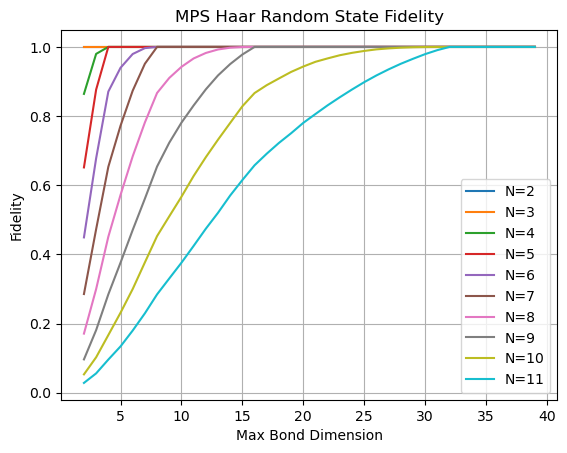

In [37]:
data = []
N_array = np.linspace(2,11, num=10, dtype=int)
x = range(2, 40)
for N in N_array:
    line = []
    print(N)
    for i in x:
        line.append(test_mps(N=N, trials=45, chi=i))
    data.append(line)

for i, line in enumerate(data):
    plt.plot(x, line, label=f'N={N_array[i]}')

plt.xlabel('Max Bond Dimension')
plt.ylabel('Fidelity')
plt.title('MPS Haar Random State Fidelity')
plt.grid(True)
plt.legend()
plt.show()

In [7]:
def binary_mps(state_v, chi=1e50):
    def rec(state_v, parent_shape, left, depth, N, chi=1e50):
        if (state_v.shape[0] == parent_shape[0] and state_v.shape[1] == parent_shape[1]) or (state_v.shape[0] == 2 and state_v.shape[1] == 2):
            if left == False and state_v.shape[1] > 2:
                state_v = np.reshape(state_v, (state_v.shape[0], 2, int(state_v.shape[1]/2)))
            elif left == True and state_v.shape[0] > 2:
                state_v = np.reshape(state_v, (int(state_v.shape[0]/2), 2, state_v.shape[1]))

            if len(state_v.shape) == 3:
                state_v = state_v[:min(len(state_v), chi), :, :min(len(state_v[0][0]), chi)]
            elif len(state_v.shape) == 2:
                state_v = state_v[:, :min(len(state_v[0]), chi)]
            return [state_v]

        new_ = 0
        if left == True:
            new_ = np.reshape(state_v, (int(state_v.shape[0]/2), state_v.shape[1]*2))
        elif left == False:
            new_ = np.reshape(state_v, (state_v.shape[0]*2, int(state_v.shape[1]/2)))

        U, S, V = np.linalg.svd(new_, full_matrices=False)

        S = S[:min(chi, len(S))]

        dims = [int(N/2), int(N/2)]
        if N %2 == 1:
            dims[1]+=1
        return rec(U, new_.shape, True, depth+1, dims[0], chi) + [np.diag(norm(S))] + rec(V, new_.shape, False, depth+1, dims[1], chi)

    N = int(np.log2(len(state_v)))
    dims = (int(N/2), int(N/2))
    if N%2==1:
        dims = (int(N/2), int(N/2)+1)
    start = np.reshape(state_v, (2**dims[0], 2**dims[1]))
    left, S, right = np.linalg.svd(start, full_matrices=False)
    S = S[:min(chi, len(S))]
    mps_v = rec(left, (0, 0), True, 1, dims[0], chi=chi) + [np.diag(norm(S))] + rec(right, (0,0), False, 1, dims[1], chi=chi)
    mps_f = []
    for i in range(0, len(mps_v)-1, 2):
        mps_f.append([mps_v[i], mps_v[i+1]])
    mps_f.append(mps_v[-1])
    return mps_f
    
st = norm(haar_state(4))
fidelity(binary_mps(st, 4), st)

1.0

In [6]:
from multiprocessing import Process, Manager

def binary_mps_parallel(state_v, chi=1e50):
    N = int(np.log2(len(state_v)))
    dims = (int(N/2), int(N/2))
    if N%2==1:
        dims = (int(N/2), int(N/2)+1)
    start = np.reshape(state_v, (2**dims[0], 2**dims[1]))
    left, S, right = np.linalg.svd(start, full_matrices=False)
    manager = Manager()
    result1 = manager.list()
    result2 = manager.list()
    rec_parallel(left, (0, 0), True, 1, dims[0], chi=chi, result=result1)
    rec_parallel(right, (0,0), False, 1, dims[1], chi=chi, result=result2)
    mps_v = list(result1) + [np.diag(norm(S))] + list(result2)
    # mps_v = rec_parallel(left, (0, 0), True, 1, dims[0], chi=chi, result=result1) + [np.diag(norm(S))] + rec_parallel(right, (0,0), False, 1, dims[1], chi=chi, result=result2)
    mps_f = []
    for i in range(0, len(mps_v)-1, 2):
        mps_f.append([mps_v[i], mps_v[i+1]])
    mps_f.append(mps_v[-1])
    return mps_f

def rec_parallel(state_v, parent_shape, left, depth, N, chi=1e50, result=None):
    if (state_v.shape[0] == parent_shape[0] and state_v.shape[1] == parent_shape[1]) or (state_v.shape[0] == 2 and state_v.shape[1] == 2):
        if left == False and state_v.shape[1] > 2:
            state_v = np.reshape(state_v, (state_v.shape[0], 2, int(state_v.shape[1]/2)))
        elif left == True and state_v.shape[0] > 2:
            state_v = np.reshape(state_v, (int(state_v.shape[0]/2), 2, state_v.shape[1]))
        result.append(state_v)
        return

    new_ = 0
    if left == True:
        new_ = np.reshape(state_v, (int(state_v.shape[0]/2), state_v.shape[1]*2))
    elif left == False:
        new_ = np.reshape(state_v, (state_v.shape[0]*2, int(state_v.shape[1]/2)))

    U, S, V = np.linalg.svd(new_, full_matrices=False)
    dims = [int(N/2), int(N/2)]
    if N % 2 == 1:
        dims[1] += 1

    Process(target=rec_parallel, args=(U, new_.shape, True, depth+1, dims[0], chi, result)).start()
    result.append(np.diag(norm(S)))
    Process(target=rec_parallel, args=(V, new_.shape, False, depth+1, dims[1], chi, result)).start()


k = norm(haar_state(10))
d = fidelity(binary_mps_parallel(k), k)


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/envs/physics14n-pset5/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/anaconda3/envs/physics14n-pset5/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'rec_parallel' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/envs/physics14n-pset5/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/anaconda3/envs/physics14n-pset5/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'rec_parallel' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 16 is different from 32)

In [30]:
# returns percent speedup of binary
def benchmark_mps(N, trials):
    avg = 0
    for i in range(trials):
        st = norm(haar_state(N))
        start = time.time()
        mps(st)
        normal = time.time()-start
        start = time.time()
        binary_mps(st)
        diff = (normal-(time.time() - start))/normal
        avg+=diff
    return avg/trials

In [31]:
def bin_test_mps(N, trials, chi, complexv=True):
    avg = 0
    for i in range(trials):
        state = norm(haar_state(N))
        m = binary_mps(state, chi=chi)
        avg += fidelity(m, state)
    return avg / trials

2
3
4
5
6
7
8
9
10
11


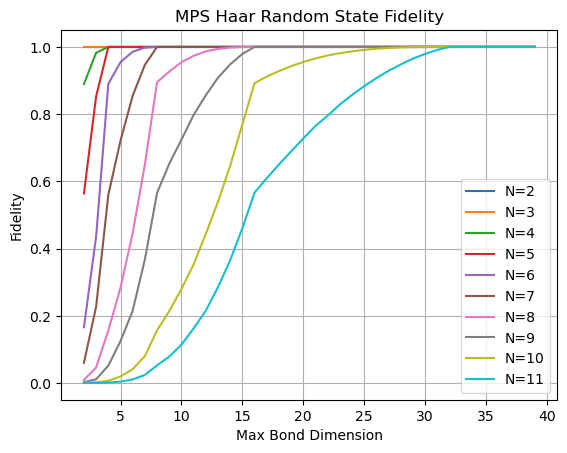

In [33]:
data = []
N_array = np.linspace(2,11, num=10, dtype=int)
x = range(2, 40)
for N in N_array:
    line = []
    print(N)
    for i in x:
        line.append(bin_test_mps(N=N, trials=45, chi=i))
    data.append(line)

for i, line in enumerate(data):
    plt.plot(x, line, label=f'N={N_array[i]}')

plt.xlabel('Max Bond Dimension')
plt.ylabel('Fidelity')
plt.title('MPS Haar Random State Fidelity')
plt.grid(True)
plt.legend()
plt.show()

In [293]:
def oqg(m, s, g):
    if s == 0:
        m[s][0] = g @ m[s][0]
    elif s == len(m)-1:
        m[s] = np.swapaxes(g @ np.swapaxes(m[s], 0, 1), 0, 1)
    else:
        site = m[s][0]
        temp = np.swapaxes(site, 0, 1)
        temp = np.reshape(temp, (2, temp.shape[1] * temp.shape[2]))
        temp = g @ temp
        temp = np.reshape(temp, (2, site.shape[0], site.shape[2]))
        temp = np.swapaxes(temp, 0, 1)
        m[s][0] = temp

# contract sites s and s+1
# returns alpha * m * n * gamma
def contract(m, s):
    if s == 0:
        prod = m[s][0] @ m[s][1] @ np.reshape(m[s+1][0], (m[s+1][0].shape[0], m[s+1][0].shape[1] * m[s+1][0].shape[2]))
        return np.reshape(prod, (prod.shape[0], 2, int(prod.shape[1]/2)))
    elif s == len(m)-2:
        prod = np.reshape(m[s][0], (m[s][0].shape[0] * m[s][0].shape[1], m[s][0].shape[2])) @ m[s][1] @ m[s+1]
        return np.reshape(prod, (int(prod.shape[0]/2), 2, prod.shape[1]))
    else:
        prod = np.reshape(m[s][0], (m[s][0].shape[0] * m[s][0].shape[1], m[s][0].shape[2])) @ m[s][1] @ np.reshape(m[s+1][0], (m[s+1][0].shape[0], m[s+1][0].shape[1] * m[s+1][0].shape[2]))
        return np.reshape(prod, (int(prod.shape[0]/2), 2, 2, int(prod.shape[1]/2)))

# g assumes form ixjxmxn
def tqg(m, s, g):
    if s >= len(m)-1:
        return
    if len(g.shape) == 2:
        g = np.reshape(g, (2, 2, 2, 2))
    g_temp = np.reshape(g, (g.shape[0] * g.shape[1], g.shape[2]*g.shape[3]))
    con = contract(m, s)
    theta = 0
    if s == 0:
        con = np.reshape(con, (con.shape[0] * con.shape[1], con.shape[2])) # mn x gamma
        theta = g_temp @ con # ij x gamma
        theta = np.reshape(theta, (g.shape[0], g.shape[1], con.shape[1])) # i x j x gamma
        theta = np.reshape(theta, (theta.shape[0], theta.shape[1]*theta.shape[2])) # i x jgamma
    elif s == len(m)-2:
        con = np.reshape(con, (con.shape[0], con.shape[1] * con.shape[2])) # alpha x mn
        con = np.swapaxes(con, 0, 1) # mn x alpha
        theta = g_temp @ con # ij x alpha
        theta = np.reshape(theta, (g.shape[0], g.shape[1], con.shape[1])) # i x j x alpha
        theta = np.swapaxes(theta, 1, 2)
        theta = np.swapaxes(theta, 0, 1) # alpha x i x j
        theta = np.reshape(theta, (theta.shape[0]*theta.shape[1], theta.shape[2])) # alphai x j
    else:
        con = np.reshape(con, (con.shape[0], con.shape[1] * con.shape[2], con.shape[3])) # alpha x mn x gamma
        con = np.swapaxes(con, 0, 1)
        con_temp = np.reshape(con, (con.shape[0], con.shape[1] * con.shape[2])) # mn x alphagamma
        theta = g_temp @ con_temp # ij x alphagamma
        theta = np.reshape(theta, (g.shape[0], g.shape[1], con.shape[1], con.shape[2])) # i x j x alpha x gamma
        theta = np.swapaxes(theta, 1, 2)
        theta = np.swapaxes(theta, 0, 1) # alpha x i x j x gamma
        theta = np.reshape(theta, (theta.shape[0]*theta.shape[1], theta.shape[2]*theta.shape[3])) # alphai x jgamma

    U, S, V = np.linalg.svd(theta, full_matrices=False)
    if s != 0:
        m[s][0] = np.reshape(U, (int(U.shape[0]/2), 2, U.shape[1]))
    else:
        m[s][0] = U
    m[s][1] = np.diag(S)
    if s != len(m)-2:
        m[s+1][0] = np.reshape(V, (V.shape[0], 2, int(V.shape[1]/2)))
    else:
        m[s+1] = V

def swapg():
    return np.reshape(np.array([[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]), (2, 2, 2, 2))

In [124]:
# st = norm(haar_state(6))
st = norm([0, 1, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
print(st)
b = mps(st)
swap_gate = np.reshape(np.array([[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]), (2, 2, 2, 2))
tqg(b, 2, swap_gate)
reconstruct(b)

[0.         0.89442719 0.4472136  0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


array([-1.57009246e-16,  4.47213595e-01,  8.94427191e-01,  1.12099769e-16,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [205]:
def tensor(A, B):
    m = len(A)*len(B)
    n = len(A[0])*len(B[0])

    prod = []

    for i in range(m):
        prod.append([])
        for j in range(n):
            ax = int(i / len(B))
            ay = int(j / len(B[0]))
            bx = int(i % len(B))
            by = int(j % len(B[0]))
            prod[i].append(A[ax][ay]*B[bx][by])

    return np.array(prod)

def tensor_list(ops):
    prod = ops[-1]
    for i in range(len(ops)-2, -1, -1):
        prod = tensor(ops[i], prod)
    return np.array(prod)

def pauli(pos, dir, N):
    factors = [[[1, 0], [0, 1]]]*N
    if dir == 0: # x
        factors[pos] = [[0, 1], [1, 0]]
    elif dir == 1: # y
        factors[pos] = [[0, -1j], [1j, 0]]
    elif dir == 2: # z
        factors[pos] = [[1, 0], [0, -1]]

    return tensor_list(factors)

def on_site_detuning(pos, N, V_nn, V_nnn):
    sum = 0
    for j in range(N):
        if np.abs(pos - j) == 1:
            sum += V_nn
        elif np.abs(pos - j) == 2:
            sum += V_nnn

    return -0.5 * sum

def interaction_strength(pos1, pos2, V_nn, V_nnn):
    if np.abs(pos1 - pos2) == 1:
        return V_nn
    if np.abs(pos1 - pos2) == 2:
        return V_nnn
    else:
        return 0

In [126]:
def gram_schmidt(v, basis):
    proj = sum([np.dot(v, b) * b for b in basis])
    w = v - proj
    # if v \in span(basis), we have reached dimension of Krylov subspace
    if np.linalg.norm(w) <= 0.001:
        return []
    return w / np.linalg.norm(w)

def krylovbasis(H, psi0, dim):
    kbasis = np.transpose(psi0)/np.linalg.norm(psi0)
    for i in range(dim-1):
        next_v = np.dot(H, kbasis[-1])
        next_v = gram_schmidt(next_v, kbasis) # orthonormalize
        if len(next_v) == 0:
            break
        kbasis = np.append(kbasis, [next_v], axis=0)

    return kbasis

def diag_power(S, n):
    for i in range(len(S)):
        S[i][i] = S[i][i]**n
    return S

# custom implementation runs into issues with numerical stability that scipy solves
# scipy uses Pade approximation, this is just an eigendecomp
def mat_exp(S):
    eigenvalues, U_inv = np.linalg.eig(S)
    U = np.linalg.inv(U_inv)
    D = np.diag([np.exp(eig) for eig in eigenvalues])
    return U @ D @ U_inv

def krylovev(H, psi0, tau, krylov_dim):
    V = np.conj(krylovbasis(H, psi0, krylov_dim))
    V_dag = np.conj(np.transpose(V))
    T = V @ H @ V_dag
    time_ev = V_dag @ expm(complex(0, -tau)*T) @ V
    return time_ev

In [234]:
def tebd(single, interactions, initial, steps, time):
    delta = time/steps
    F = [] # odd
    G = [] # even

    states = [reconstruct(initial)]

    for i in range(len(initial)):
        h = np.zeros((4,4))
        for j in range(len(interactions)):
            h = np.add(h, interactions[j] * pauli(0, j, 2) @ pauli(1, j, 2))
        for j in range(len(single)):
            h = np.add(h, single[j] * pauli(0, j, 2))
        h = -0.5*h

        if i % 2 == 1:
            F.append(scipy.linalg.expm(complex(0, -delta/2)*h))
        else:
            G.append(scipy.linalg.expm(complex(0, -delta)*h))

    for i in range(steps):
        for j in range(len(F)):
            tqg(initial, j*2+1, F[j])
        for j in range(len(G)):
            tqg(initial, j*2, G[j])
        for j in range(len(F)):
            tqg(initial, j*2+1, F[j])
        states.append(reconstruct(initial))
    return states

In [295]:
def apply_nnn_gate(state, s, g):
    if s > len(state)-3:
        return
    tqg(state, s+1, swapg())
    tqg(state, s, g)
    tqg(state, s+1, swapg())

def swap_tebd(onsite_weight, nn, nnn, initial, steps, time):
    delta = time/steps

    nnn_gate = np.zeros((4,4))
    nn_gate = np.zeros((4,4))
    for j in range(3):
        nnn_gate = np.add(nnn_gate, nnn[j]*pauli(0, j, 2) @ pauli(1, j, 2))
        nn_gate = np.add(nn_gate, nn[j] * pauli(0, j, 2) @ pauli(1, j, 2))

    nnn_gate_half = scipy.linalg.expm(complex(0, -delta/2)*nnn_gate)
    nnn_gate = scipy.linalg.expm(complex(0, -delta)*nnn_gate)

    nn_gate_half = scipy.linalg.expm(complex(0, -delta/2)*nn_gate)
    nn_gate = scipy.linalg.expm(complex(0, -delta)*nn_gate)

    states = [reconstruct(initial)]

    onsite = []
    for i in range(len(initial)):
        h = np.zeros((2, 2))
        for j in range(3):
            h = np.add(h, onsite_weight(i, j) * pauli(0, j, 1))
        onsite.append(h)

    for i in range(steps):
        for s in range(2, len(initial), 3):
            apply_nnn_gate(initial, s, nnn_gate_half)
            tqg(initial, s, nn_gate_half)
            oqg(initial, s, scipy.linalg.expm(complex(0, -delta/2)*onsite[s]))
        for s in range(1, len(initial), 3):
            apply_nnn_gate(initial, s, nnn_gate_half)
            tqg(initial, s, nn_gate_half)
            oqg(initial, s, scipy.linalg.expm(complex(0, -delta/2)*onsite[s]))
        for s in range(0, len(initial), 3):
            apply_nnn_gate(initial, s, nnn_gate)
            tqg(initial, s, nn_gate)
            oqg(initial, s, scipy.linalg.expm(complex(0, -delta)*onsite[s]))
        for s in range(1, len(initial), 3):
            apply_nnn_gate(initial, s, nnn_gate_half)
            tqg(initial, s, nn_gate_half)
            oqg(initial, s, scipy.linalg.expm(complex(0, -delta/2)*onsite[s]))
        for s in range(2, len(initial), 3):
            apply_nnn_gate(initial, s, nnn_gate_half)
            tqg(initial, s, nn_gate_half)
            oqg(initial, s, scipy.linalg.expm(complex(0, -delta/2)*onsite[s]))
        states.append(reconstruct(initial))
    return states

In [267]:
initial = mps(norm(haar_state(4)))
initial = mps(norm([1, 0, 0, 0, 0, 0, 0, 0]))
print(reconstruct(initial))
swap_tebd([2*np.pi*6.4*(10**6), 0, 2*2*np.pi*60*(10**6) + 2*2*np.pi*2.3*(10**6)], [0, 0, 2*np.pi*60*(10**6)], [0,0,0], initial, 100, 475*(10**-9))
print(reconstruct(initial))

[1. 0. 0. 0. 0. 0. 0. 0.]
[-0.04284889-0.99735985j  0.        +0.j          0.04142706-0.03285989j
  0.        +0.j         -0.01809642-0.01754961j  0.        +0.j
  0.00114756-0.00212994j  0.        +0.j        ]


/opt/anaconda3/envs/physics14n-pset5/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/physics14n-pset5/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/physics14n-pset5/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/physics14n-pset5/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/physics14n-pset5/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  ret

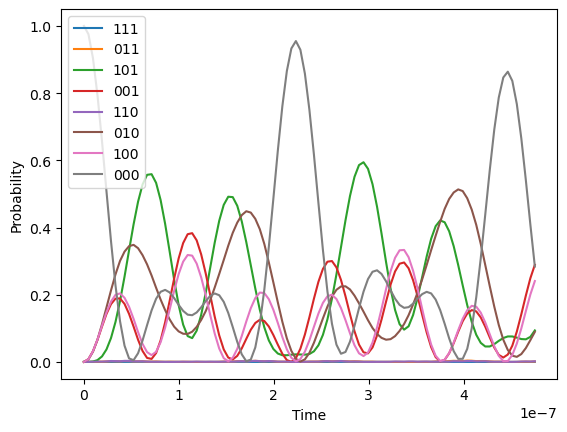

In [298]:
rabi_f = 2*np.pi*6.4*(10**6) # rabi frequency for Rydberg to ground state cycles (Hz)
V_nn = 2*np.pi*60*(10**6) # nearest neighbors interaction strength (Hz) (ref page 180, strongly interacting pairs)
V_nnn = 2*np.pi*2.3*(10**6) # next nearest neighbors interaction strength (Hz)
time = 475*(10**-9)
steps = 100
tlist = np.linspace(0.0, time, steps+1)
N = 3

initial_state = mps(tensor_list([[[0], [1]]] * N))

nn = np.array([0,0,V_nn])
nnn = np.array([0, 0, V_nnn])

def onsite_weight(pos, dir):
    if dir == 0:
        return 0.5*rabi_f
    elif dir == 1:
        return 0
    else:
        return -0.5*on_site_detuning(pos, N, V_nn, V_nnn)

evs = np.array(swap_tebd(onsite_weight, 0.25*nn, 0.25*nnn, initial_state, steps, time))
for i in range(len(evs)):
    evs[i] = np.abs(evs[i])**2

plt.figure()
for s in range(8):
   plt.plot(tlist, evs[:, s])
plt.legend(('111', '011', '101', '001', '110', '010', '100', '000'))
plt.xlabel('Time')
plt.ylabel('Probability')
plt.show()